In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [39]:
# Load and prepare dataset
dataset = pd.read_csv("/kaggle/input/retail-analysis-with-walmart-data/Walmart_Store_sales.csv")
dataset['Date'] = pd.to_datetime(dataset['Date'], dayfirst=True)
dataset['Days_since_start'] = (dataset['Date'] - dataset['Date'].min()).dt.days

In [40]:
# Store with maximum with sales
store_sales = dataset.groupby('Store')['Weekly_Sales'].sum()
max_store = store_sales.idxmax()
max_sales = store_sales.max()
print(f"Store with maximum sales: {max_store}")
print(f"Maximum Sales Amount: {max_sales}")

Store with maximum sales: 20
Maximum Sales Amount: 301397792.46


In [41]:
# Store with maximum standard deviation and coeffecient of variation
store_stats = dataset.groupby('Store')['Weekly_Sales'].agg(['mean','std'])
store_stats['coefficient of variation'] = store_stats['std']/store_stats['mean']

max_store_std = store_stats['std'].idxmax()
max_std = store_stats['std'].max()

max_store_cv = store_stats['coefficient of variation'].idxmax()
max_cv = store_stats['coefficient of variation'].max()

print(f"Store with maximum standard deviation: {max_store_std}")
print(f"Maximum Standard Deviation: {max_std}")
print(f"Store with maximum Coefficient of Variation: {max_store_cv}")
print(f"Coefficient of Variation: {max_cv}")

Store with maximum standard deviation: 14
Maximum Standard Deviation: 317569.9494755081
Store with maximum Coefficient of Variation: 35
Coefficient of Variation: 0.2296811138997643


In [42]:
# Store with maximum quarterly growth rate
q2_start = pd.to_datetime('2012-04-01')
q2_end = pd.to_datetime('2012-06-30')
q3_start = pd.to_datetime('2012-07-01')
q3_end = pd.to_datetime('2012-09-30')

q2_data = dataset[(dataset['Date'] >= q2_start) & (dataset['Date'] <= q2_end)]
q3_data = dataset[(dataset['Date'] >= q3_start) & (dataset['Date'] <= q3_end)]

q2_sales = q2_data.groupby('Store')['Weekly_Sales'].sum()
q3_sales = q3_data.groupby('Store')['Weekly_Sales'].sum()

growth_df = pd.DataFrame({'Q2_Sales_2012':q2_sales,'Q3_Sales_2012':q3_sales})
growth_df['Growth_Rate %'] = ((growth_df['Q3_Sales_2012']-growth_df['Q2_Sales_2012'])/growth_df['Q2_Sales_2012'])*100

growth_df_sorted = growth_df.sort_values(by = 'Growth_Rate %', ascending = False)

print("Stores with highest growth rate for Q2'2012")
print(growth_df_sorted.head(10))

Stores with highest growth rate for Q2'2012
       Q2_Sales_2012  Q3_Sales_2012  Growth_Rate %
Store                                             
7         7290859.27     8262787.39      13.330776
16        6564335.98     7121541.64       8.488378
35       10838313.00    11322421.12       4.466637
26       13155335.57    13675691.91       3.955478
39       20214128.46    20715116.23       2.478404
41       17659942.73    18093844.01       2.456980
44        4306405.78     4411251.16       2.434638
24       17684218.91    17976377.72       1.652088
40       12727737.53    12873195.37       1.142841
23       18488882.82    18641489.15       0.825395


In [43]:
holiday_data = dataset[dataset['Holiday_Flag'] == 1]
non_holiday_data = dataset[dataset['Holiday_Flag'] == 0]

holiday_sales = holiday_data.groupby('Date')['Weekly_Sales'].sum()
mean_non_holiday_sales = non_holiday_data['Weekly_Sales'].mean()

higher_sales = holiday_sales[holiday_sales > mean_non_holiday_sales]

sorted_sales = higher_sales.sort_values(ascending = False)

sorted_sales

Date
2011-11-25    66593605.26
2010-11-26    65821003.24
2012-02-10    50009407.92
2010-02-12    48336677.63
2012-09-07    48330059.31
2011-02-11    47336192.79
2011-09-09    46763227.53
2011-12-30    46042461.04
2010-09-10    45634397.84
2010-12-31    40432519.00
Name: Weekly_Sales, dtype: float64

In [44]:
# Filter data for Store 1
store_1 = dataset[dataset['Store'] == 1].copy()

In [45]:
# Select features and target
features = ['Days_since_start', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
store_1_X = store_1[features].values
store_1_y = store_1['Weekly_Sales'].values
m = len(store_1_y)

In [46]:
# Feature and target scaling
scalerX = StandardScaler()
scalerY = StandardScaler()

X_scaled = scalerX.fit_transform(store_1_X)
y_scaled = scalerY.fit_transform(store_1_y.reshape(-1, 1)).flatten()

In [47]:
# Add bias column to feature matrix
x_b = np.c_[np.ones((m, 1)), X_scaled]

In [48]:
#Exract Holidays values
holiday_flag = store_1['Holiday_Flag'].values

# Gradient Descent implementation
def gradientdescent(X, y,holiday_flag, iterations=4000, learning_rate=0.17, stopping_threshold=1e-30):
    m, n = X.shape
    previous_cost = None
    weights = np.zeros(n)

    sample_weights = np.where(holiday_flag == 1,5,1)

    for i in range(iterations):
        y_predict = X.dot(weights)
        error = y - y_predict
        weighted_error = error*sample_weights
        current_cost = (1/m) * np.sum(sample_weights*(error ** 2))

        if previous_cost is not None and abs(previous_cost - current_cost) <= stopping_threshold:
            break

        gradient = -(2/m) * X.T.dot(weighted_error)
        weights = weights - (learning_rate * gradient)
        previous_cost = current_cost
    return weights

In [49]:
# Train the model
weights = gradientdescent(x_b, y_scaled,holiday_flag)

In [50]:
# Function to make predictions
def predict_sales(date_str, holiday_flag, temp, fuel_price, cpi, unemployment):
    # Step 1: Convert date to "days since start"
    test_date = pd.to_datetime(date_str, dayfirst=True)
    days_since_start = (test_date - dataset['Date'].min()).days

    # Step 2: Create and scale test input
    test_values = np.array([[days_since_start, holiday_flag, temp, fuel_price, cpi, unemployment]])
    test_scaled = scalerX.transform(test_values)
    test_scaled_b = np.hstack([[1], test_scaled.flatten()])

    # Step 3: Predict and inverse scale the output
    scaled_prediction = np.dot(test_scaled_b, weights)
    final_prediction = scalerY.inverse_transform([[scaled_prediction]])[0][0]
    return final_prediction

In [51]:
# Accuracy Evaluation
n = 55
testx_values = dataset[features][:n].values
testx_scaled = scalerX.transform(testx_values)
testx_b = np.c_[np.ones((n,1)), testx_scaled]
testy_values = dataset['Weekly_Sales'][:n].values
predict_history = []
for i in range(n):
    y_predict = np.dot(testx_b[i],weights)
    y_predict_inv = scalerY.inverse_transform([[y_predict]])[0][0]
    predict_history.append(y_predict_inv)
    print(f"{i+1} Predicted Sale: {y_predict_inv}, Actual Sale: {testy_values[i]}")

1 Predicted Sale: 1564629.2632463835, Actual Sale: 1643690.9
2 Predicted Sale: 1670182.9850509218, Actual Sale: 1641957.44
3 Predicted Sale: 1574005.6392270573, Actual Sale: 1611968.17
4 Predicted Sale: 1563320.155698196, Actual Sale: 1409727.59
5 Predicted Sale: 1561066.953766815, Actual Sale: 1554806.68
6 Predicted Sale: 1544421.385699634, Actual Sale: 1439541.59
7 Predicted Sale: 1543064.6357309124, Actual Sale: 1472515.79
8 Predicted Sale: 1542845.380058585, Actual Sale: 1404429.92
9 Predicted Sale: 1501448.3165166622, Actual Sale: 1594968.28
10 Predicted Sale: 1490388.5799569325, Actual Sale: 1545418.53
11 Predicted Sale: 1485361.6683535355, Actual Sale: 1466058.28
12 Predicted Sale: 1486904.439984192, Actual Sale: 1391256.12
13 Predicted Sale: 1483078.2118795298, Actual Sale: 1425100.71
14 Predicted Sale: 1472591.4182449698, Actual Sale: 1603955.12
15 Predicted Sale: 1468575.5730807097, Actual Sale: 1494251.5
16 Predicted Sale: 1472898.7654578341, Actual Sale: 1399662.07
17 Predi

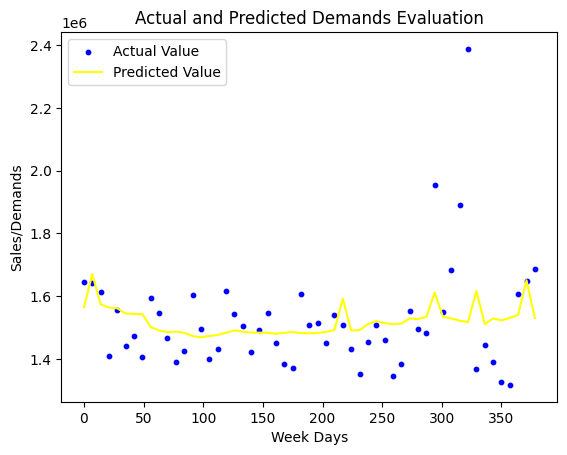

In [52]:
import matplotlib.pyplot as plt

week_days = dataset['Days_since_start'][:n].values

plt.scatter(week_days, testy_values,color = 'blue', label = 'Actual Value', s = 10)
plt.plot(week_days,predict_history,color = 'yellow', label = 'Predicted Value')
plt.xlabel('Week Days')
plt.ylabel('Sales/Demands')
plt.title('Actual and Predicted Demands Evaluation')
plt.legend()
plt.show()